# Imports

In [1]:
#%matplotlib widget
%matplotlib inline

import numpy as np
from random import randrange
from matplotlib import pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.metrics import classification_report,auc,r2_score,matthews_corrcoef
from catboost import CatBoostRegressor,CatBoostClassifier
from catboost.utils import get_roc_curve
import shap
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 300)
from sklearn import preprocessing
from catboost import Pool, cv
from scipy import stats
from scipy.optimize import curve_fit
from tqdm import tqdm
from numpy.random import RandomState
from scipy import stats
import pickle
import os
import ast
import seaborn as sns

# Prognostic vs Predictive
Based on paper: "On Discovering Treatment-Effect  Modifiers Using Virtual Twins  and Causal Forest ML in the Presence  of Prognostic Biomarkers"

## Simulation Datasets

In [3]:
ground_truth_pred_features = []
ground_truth_informative_features = []

def M1(T, x_features, N, npRandomState, noise_std = 1):
    global ground_truth_pred_features, ground_truth_informative_features
    ground_truth_pred_features =['x6', 'x7','T']
    ground_truth_informative_features =['x0','x1','x2','x3','x4','x6','x7']

    epsilon = npRandomState.normal(0, noise_std, N)
    return -1+3*(x_features[:, 0]+x_features[:, 1]+x_features[:, 2]+x_features[:, 3]+x_features[:, 4])+T*((x_features[:, 6] > 0).astype(int)*(x_features[:, 7] > 0).astype(int))+epsilon


def M2(T, x_features, N, npRandomState, noise_std = 1):
    global ground_truth_pred_features, ground_truth_informative_features
    ground_truth_pred_features = ['x0','T']
    ground_truth_informative_features =['x0','x1','x2','x3','x4']

    epsilon = npRandomState.normal(0, noise_std, N)
    return -1+3*(x_features[:, 0]+x_features[:, 1]+x_features[:, 2]+x_features[:, 3]+x_features[:, 4])+T*((x_features[:, 0] > 0).astype(int))+epsilon


def M3(T, x_features, N, npRandomState, noise_std = 1):
    global ground_truth_pred_features, ground_truth_informative_features
    ground_truth_pred_features =['x19','T']
    ground_truth_informative_features =['x0','x1','x2','x3','x4','x19']

    epsilon = npRandomState.normal(0, noise_std, N)
    return -1+3*(x_features[:, 0]+x_features[:, 1]+x_features[:, 2]+x_features[:, 3]+x_features[:, 4])+T*((x_features[:, 19] > 0).astype(int))+epsilon 


def M4(T, x_features, N, npRandomState, noise_std = 1):
    global ground_truth_pred_features, ground_truth_informative_features
    ground_truth_pred_features = []
    ground_truth_informative_features =['x0','x1','x2','x3','x4']

    epsilon = npRandomState.normal(0, noise_std, N)
    return -1+3*(x_features[:, 0]+x_features[:, 1]+x_features[:, 2]+x_features[:, 3]+x_features[:, 4])+epsilon


def M5(T, x_features, N, npRandomState, noise_std = 1):
    global ground_truth_pred_features, ground_truth_informative_features
    ground_truth_pred_features = ['x9', 'x10', 'x11', 'x12', 'x13', 'x14','T']
    ground_truth_informative_features =['x0','x1','x2','x3','x4','x9', 'x10', 'x11', 'x12', 'x13', 'x14']

    epsilon = npRandomState.normal(0, noise_std, N)
    return -1+3*(x_features[:, 0]+x_features[:, 1]+x_features[:, 2]+x_features[:, 3]+x_features[:, 4])+T*(x_features[:, 9]+x_features[:, 10]+x_features[:, 11]+x_features[:, 12]+x_features[:, 13]+x_features[:, 14])+epsilon


def M6(T, x_features, N, npRandomState, noise_std = 1):
    global ground_truth_pred_features, ground_truth_informative_features
    ground_truth_pred_features = ['x4','T']
    ground_truth_informative_features =['x0','x1','x2','x3','x4']

    epsilon = npRandomState.normal(0, noise_std, N)
    return -1+3*((x_features[:, 0] > 0).astype(int)+(x_features[:, 1] > 0).astype(int)+(x_features[:, 2] > 0).astype(int)+(x_features[:, 3] > 0).astype(int)+(x_features[:, 4] > 0).astype(int))+T*((x_features[:, 4] > 0).astype(int))+epsilon


def M7(T, x_features, N, npRandomState, noise_std = 1):
    global ground_truth_pred_features, ground_truth_informative_features
    ground_truth_pred_features = ['x19','T']
    ground_truth_informative_features =['x0','x1','x2','x3','x4','x5','x6','x7','x8','x9','x19']

    epsilon = npRandomState.normal(0, noise_std, N)
    return -1+3*(x_features[:, 0]+x_features[:, 1]+x_features[:, 2]+x_features[:, 3]+x_features[:, 4]+x_features[:, 5]+x_features[:, 6]+x_features[:, 7]+x_features[:, 8]+x_features[:, 9])+T*((x_features[:, 19] > 0).astype(int))+epsilon


def M8(T, x_features, N, npRandomState, noise_std = 1):
    global ground_truth_pred_features, ground_truth_informative_features
    ground_truth_pred_features = ['x0','T']
    ground_truth_informative_features =['x0','x1','x2','x3','x4','x5','x6','x7','x8','x9']

    epsilon = npRandomState.normal(0, noise_std, N)
    return -1+3*(x_features[:, 0]+x_features[:, 1]+x_features[:, 2]+x_features[:, 3]+x_features[:, 4]+x_features[:, 5]+x_features[:, 6]+x_features[:, 7]+x_features[:, 8]+x_features[:, 9])+T*((x_features[:, 0] > 0).astype(int))+epsilon


def M9(T, x_features, N, npRandomState, noise_std = 1):
    global ground_truth_pred_features, ground_truth_informative_features
    ground_truth_pred_features = ['x0','T']
    ground_truth_informative_features =['x0','x1','x2','x3','x4']

    epsilon = npRandomState.normal(0, noise_std, N)
    return -1+3*(x_features[:, 0]+x_features[:, 1]+x_features[:, 2]+x_features[:, 3]+x_features[:, 4])+T*np.sin(x_features[:, 0])+epsilon


def M10(T, x_features, N, npRandomState, noise_std = 1):
    global ground_truth_pred_features, ground_truth_informative_features
    ground_truth_pred_features = ['x0','T']
    ground_truth_informative_features =['x0','x1','x2','x3','x4']

    epsilon = npRandomState.normal(0, noise_std, N)
    return -1+10*(x_features[:, 0]+x_features[:, 1]+x_features[:, 2]+x_features[:, 3]+x_features[:, 4])+T*((x_features[:, 0] > 0).astype(int))+epsilon


def M11(T, x_features, N, npRandomState, noise_std = 1):
    global ground_truth_pred_features, ground_truth_informative_features
    ground_truth_pred_features = ['x0','T']
    ground_truth_informative_features =['x0','x1','x2','x3','x4']

    epsilon = npRandomState.normal(0, noise_std, N)
    return -1+(x_features[:, 0]+x_features[:, 1]+x_features[:, 2]+x_features[:, 3]+x_features[:, 4])**3+T*((x_features[:, 0])**3)+epsilon


def M12(T, x_features, N, npRandomState, noise_std = 1):
    global ground_truth_pred_features, ground_truth_informative_features
    ground_truth_pred_features = ['x0','T']
    ground_truth_informative_features =['x0','x1','x2','x3','x4']

    epsilon = npRandomState.normal(0, noise_std, N)
    return -1+3*(x_features[:, 0]+x_features[:, 1]+x_features[:, 2]+x_features[:, 3]+x_features[:, 4])+T*(x_features[:, 0])+epsilon


def M13(T, x_features, N, npRandomState, noise_std = 1):
    global ground_truth_pred_features, ground_truth_informative_features
    ground_truth_pred_features = ['x19','T']
    ground_truth_informative_features =['x0','x1','x2','x3','x4','x19']

    epsilon = npRandomState.normal(0, noise_std, N)
    return -1+3*(x_features[:, 0]+x_features[:, 1]+x_features[:, 2]+x_features[:, 3]+x_features[:, 4])+T*(x_features[:, 19])+epsilon


def M14(T, x_features, N, npRandomState, noise_std = 1):
    global ground_truth_pred_features, ground_truth_informative_features
    ground_truth_pred_features = ['x6','x7','T']
    ground_truth_informative_features =['x0','x1','x2','x3','x4','x6','x7']

    epsilon = npRandomState.normal(0, noise_std, N)
    return -1+3*(x_features[:, 0]+x_features[:, 1]+x_features[:, 2]+x_features[:, 3]+x_features[:, 4])+50*T*((x_features[:, 6] > 0).astype(int)*(x_features[:, 7] > 0).astype(int))+epsilon


def M15(T, x_features, N, npRandomState, noise_std = 1):
    global ground_truth_pred_features, ground_truth_informative_features
    ground_truth_pred_features = ['x0','T']
    ground_truth_informative_features =['x0','x1','x2','x3','x4']

    epsilon = npRandomState.normal(0, noise_std, N)
    return -1+3*(x_features[:, 0]+x_features[:, 1]+x_features[:, 2]+x_features[:, 3]+x_features[:, 4])+50*T*((x_features[:, 0] > 0).astype(int))+epsilon


def M16(T, x_features, N, npRandomState, noise_std = 1):
    global ground_truth_pred_features, ground_truth_informative_features
    ground_truth_pred_features = ['x0', 'x1', 'x7','T']
    ground_truth_informative_features =['x0','x1','x2','x3','x4','x7']

    epsilon = npRandomState.normal(0, noise_std, N)
    return -1+3*(x_features[:, 0]+x_features[:, 1]+x_features[:, 2]+x_features[:, 3]+x_features[:, 4])+T*((x_features[:, 0] > 0).astype(int)+10*(x_features[:, 1] > 0).astype(int)+5*(x_features[:, 7] > 0).astype(int))+epsilon

def M17(T, x_features, N, npRandomState, noise_std = 1):
    global ground_truth_pred_features, ground_truth_informative_features
    ground_truth_pred_features = ['x5','T']
    ground_truth_informative_features =['x0','x1','x2','x3','x4','x5']

    epsilon = npRandomState.normal(0, noise_std, N)
    return -1+10*(x_features[:, 0]+x_features[:, 1]+x_features[:, 2]+x_features[:, 3]+x_features[:, 4])+T*((x_features[:, 5] > 0).astype(int))+epsilon


def M18(T, x_features, N, npRandomState, noise_std = 1):
    global ground_truth_pred_features, ground_truth_informative_features
    ground_truth_pred_features = ['x5','T']
    ground_truth_informative_features =['x0','x1','x2','x3','x4','x5']

    epsilon = npRandomState.normal(0, noise_std, N)
    return -1+(x_features[:, 0]+x_features[:, 1]+x_features[:, 2]+x_features[:, 3]+x_features[:, 4])**3+T*((x_features[:, 5])**3)+epsilon

def M_DGP(T, x_features, x_columns, N, npRandomState,d_pred,d_prog,thresh,w_pred,std_noise):
    global ground_truth_pred_features, ground_truth_informative_features, alpha_pred, alpha_prog

    epsilon = npRandomState.normal(0, std_noise, N)
    alpha_prog = npRandomState.uniform(-1,1,len(x_columns))
    alpha_pred = npRandomState.uniform(-1,1,len(x_columns))

    pred_above_threshold = np.where(np.abs(alpha_pred) > thresh)[0]
    prog_above_threshold = np.where(np.abs(alpha_prog) > thresh)[0]

    pred_features_alpha = np.sort(npRandomState.choice(pred_above_threshold,d_pred,replace=False))
    prog_features_alpha = np.sort(npRandomState.choice(prog_above_threshold,d_prog,replace=False))

    for i in range(len(x_columns)):
        if i not in pred_features_alpha:
            alpha_pred[i] = 0
        if i not in prog_features_alpha:
            alpha_prog[i] = 0

    ground_truth_pred_features = list(x_columns[pred_features_alpha])+['T']
    ground_truth_informative_features = list(set(list(x_columns[prog_features_alpha]) + list(x_columns[pred_features_alpha])))

    mu_prog = np.sum(alpha_prog * x_features,axis=1)
    mu_pred = np.sum(alpha_pred * x_features,axis=1)

    return mu_prog + T * w_pred * mu_pred + epsilon

def T0(x_features, N, npRandomState):
    return npRandomState.randint(0, 2, N)

def T1(x_features, N, npRandomState):
    logit_t1 = 0.1+0.5*x_features[:, 1]-0.25*(2+x_features[:, 2])

    return npRandomState.binomial(1, np.exp(logit_t1)/(1+np.exp(logit_t1)), N)


def T2(x_features, N, npRandomState):
    logit_t1 = 0.1+1.5*(1+x_features[:, 1])-0.25*x_features[:, 2]

    return npRandomState.binomial(1, np.exp(logit_t1)/(1+np.exp(logit_t1)), N)


## Functions

In [6]:
from scipy.stats import rankdata, norm, chi2

def cumsum_kstest(A,B):
    A = np.sort(A)
    B = np.sort(B)
    na = A.shape[0]
    nb = B.shape[0]

    data_all = np.sort(np.concatenate([A,B]))

    cdf1 = np.searchsorted(A, data_all, side='right') / na

    cdf2 = np.searchsorted(B, data_all, side='right') / nb
    
    cddiffs = cdf1 - cdf2

    return data_all, cdf1, cdf2, cddiffs

def fligner_own(X,Y):
    Ni = np.array([len(X),len(Y)])
    Yci = np.array([np.median(X),np.median(Y)])
    Ntot = np.sum(Ni)

    Zij = [np.abs(np.array(X-Yci[0])),np.abs(np.array(Y-Yci[1]))]

    ZijAll = []
    for el in Zij:
        ZijAll.extend(list(el))
    
    ranks = rankdata(ZijAll)
    
    # to find a X (or x times std) away from the mean of the distribution, that is why it is times two and + 0.5
    sample = norm.ppf(ranks / (2*(Ntot + 1)) + 0.5) 

    Aibar = [np.sum(sample[:Ni[0]]),np.sum(sample[Ni[0]:])]/Ni
    anbar = np.mean(sample,axis=0)
    varsq = np.var(sample,axis=0,ddof=1)

    Xsq = np.sum(Ni * (np.array(Aibar) - anbar)**2.0, axis = 0) / varsq

    pval = 1 - chi2.cdf(Xsq, 1) # 1-cdf

    return Xsq,pval

def equisample_array_target(sample_array,reduce_array,N_bins = 5000):
    pseudo_array = np.arange(np.min(sample_array),np.max(sample_array),(np.max(sample_array) - np.min(sample_array))/N_bins)
    reduce_array_return = []

    for i in range(N_bins):
        sample_element = pseudo_array[i]
        idx = np.max(np.where(sample_array <= sample_element))
        new_element_reduce = reduce_array[idx]
        reduce_array_return.append(new_element_reduce)

    return np.array(reduce_array_return),pseudo_array

def s(X):
    return np.sqrt(1/len(X) * np.sum((X-np.mean(X))**2))

def compensated_welchs_ttest(A,B,R_A,R_B):

    t = (np.mean(A)-np.mean(B))/(np.sqrt((s(A) /np.sqrt(len(A)))**2+(s(B)/np.sqrt(len(B)))**2))

    t_random = (np.mean(R_A)-np.mean(R_B))/(np.sqrt((s(R_A) /np.sqrt(len(R_A)))**2+(s(R_B)/np.sqrt(len(R_B)))**2))

    df_A = len(A)-1
    df_B = len(B)-1

    deg_free = (s(A)**2+s(B)**2)**2 / (1/df_A * s(A)**4 + 1/df_B * s(B)**4)

    p_value_comp = (np.min([st.t.cdf(t - t_random,df=deg_free),1-st.t.cdf(t - t_random,df=deg_free)]))*2

    return t-t_random, p_value_comp

def calculate_pvalues(df):
    dfcols = pd.DataFrame(columns=df.columns)
    pvalues = dfcols.transpose().join(dfcols, how='outer')
    for r in df.columns:
        for c in df.columns:
            tmp = df[df[r].notnull() & df[c].notnull()]
            pvalues[r][c] = round(spearmanr(tmp[r], tmp[c])[1], 4)
    return pvalues

def SNR_synthetic(data_array,noise_std):
    return 10*np.log(np.mean(data_array**2)/(noise_std**2))

## DGP Datasets

In [7]:
dataset_string = "NEWS" #ACIC, TWINS, NEWS, TCGA

if dataset_string == "TWINS":
    x = pd.read_csv("Datasets/Twins_dataset.csv")

    DGP_df = x[['pldel', 'birattnd', 'brstate',
       'stoccfipb', 'mager8', 'ormoth', 'mrace', 'meduc6', 'dmar',
       'mplbir', 'mpre5', 'adequacy', 'orfath', 'frace', 'birmon',
       'gestat10', 'csex', 'anemia', 'cardiac', 'lung', 'diabetes',
       'herpes', 'hydra', 'hemo', 'chyper', 'phyper', 'eclamp',
       'incervix', 'pre4000', 'preterm', 'renal', 'rh', 'uterine',
       'othermr', 'tobacco', 'alcohol', 'cigar6', 'drink5', 'crace',
       'data_year', 'nprevistq', 'dfageq', 'feduc6', 'dlivord_min', 'dtotord_min', 
       'brstate_reg', 'stoccfipb_reg', 'mplbir_reg']].copy(deep=True)

    DGP_df = DGP_df.fillna(0)

    DGP_df.to_csv("Twins_dataset",index=False)

elif dataset_string == "ACIC":
    DGP_df = pd.read_csv("Datasets/ACIC2016_dataset.csv")

elif dataset_string == "NEWS":
    dgp_file = open("Datasets/news_100_features_dataset.p", 'rb')
    DGP_array = pickle.load(dgp_file)
    DGP_df = pd.DataFrame(data=DGP_array,columns=["x"+str(i) for i in range(np.shape(DGP_array)[1])])
    DGP_array = None

elif dataset_string == "TCGA":
    dgp_file = open("Datasets/tcga_100_features_dataset.p", 'rb')
    DGP_array = pickle.load(dgp_file)
    DGP_array = DGP_array['rnaseq']
    DGP_df = pd.DataFrame(data=DGP_array,columns=["x"+str(i) for i in range(np.shape(DGP_array)[1])])
    DGP_array = None


threshold_value = 0.02
keep_cols = []

for col in DGP_df.columns.values:
    percentage_diff_values = DGP_df[col].value_counts().reset_index(drop=True)[1:].sum() / len(DGP_df)
    if percentage_diff_values >= threshold_value:
        keep_cols.append(col)

DGP_df = DGP_df[keep_cols]

i = 0
for col in keep_cols:
    DGP_df = DGP_df.rename(columns={col:"x"+str(i)})
    i += 1 

DGP_df

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,x15,x16,x17,x18,x19,x20,x21,x22,x23,x24,x25,x26,x27,x28,x29,x30,x31,x32,x33,x34,x35,x36,x37,x38,x39,x40,x41,x42,x43,x44,x45,x46,x47,x48,x49,x50,x51,x52,x53,x54,x55,x56,x57,x58,x59,x60,x61,x62,x63,x64,x65,x66,x67,x68,x69,x70,x71,x72,x73,x74,x75,x76,x77,x78,x79,x80,x81,x82,x83,x84,x85,x86,x87,x88,x89,x90,x91,x92,x93,x94,x95,x96,x97,x98,x99
0,0.374601,0.303594,0.202278,0.387721,0.171826,0.314659,0.398340,0.197056,0.285733,0.215948,0.500027,0.466278,0.301435,0.502475,0.232182,0.422610,0.362295,0.513785,0.536267,0.317531,0.284488,0.274228,0.413619,0.576815,0.458812,0.727100,0.379272,0.377066,0.222521,0.343260,0.453741,0.467833,0.460294,0.317654,0.424908,0.378299,0.492011,0.405834,0.272957,0.471709,0.436885,0.534022,0.343161,0.419781,0.281688,0.487031,0.584721,0.374886,0.388136,0.316403,0.340359,0.356651,0.389700,0.196976,0.493396,0.468541,0.421133,0.509623,0.540472,0.418029,0.426033,0.515089,0.465581,0.421294,0.420402,0.438664,0.393198,0.415956,0.452135,0.412473,0.314468,0.378623,0.458105,0.385540,0.421364,0.423236,0.422950,0.326758,0.494737,0.428240,0.406495,0.426190,0.487197,0.483225,0.350320,0.494670,0.468780,0.383108,0.296648,0.493076,0.294601,0.195567,0.429201,0.349105,0.363532,0.236476,0.193442,0.168369,0.373844,0.480011
1,0.382396,0.337081,0.284364,0.411720,0.165472,0.307419,0.468726,0.268527,0.308672,0.280210,0.464298,0.476204,0.321565,0.507985,0.267631,0.343652,0.272242,0.468232,0.534093,0.289327,0.345871,0.312183,0.468330,0.494621,0.358519,0.362634,0.342739,0.259772,0.369911,0.434049,0.534049,0.362043,0.441057,0.296533,0.410161,0.418953,0.445818,0.455290,0.335520,0.459910,0.459340,0.526854,0.353720,0.467245,0.259344,0.507541,0.459350,0.474187,0.412764,0.245073,0.221372,0.305178,0.413199,0.239434,0.470290,0.488245,0.331116,0.334482,0.500861,0.428032,0.286999,0.271745,0.468415,0.438657,0.499077,0.392740,0.311553,0.347105,0.508440,0.361758,0.265757,0.387452,0.381808,0.341163,0.505841,0.400444,0.321721,0.404518,0.498721,0.482210,0.370190,0.375358,0.398446,0.388574,0.404141,0.493925,0.454098,0.475604,0.217891,0.450696,0.303985,0.193445,0.395927,0.390338,0.402807,0.258737,0.235748,0.161383,0.241275,0.454156
2,0.272323,0.420122,0.356422,0.330663,0.132794,0.384198,0.455654,0.259581,0.290792,0.229859,0.413742,0.427869,0.320757,0.461711,0.241077,0.384032,0.482045,0.491426,0.560102,0.325470,0.428062,0.313178,0.458003,0.498547,0.311679,0.356761,0.382354,0.272836,0.277593,0.398767,0.532025,0.526547,0.403831,0.248551,0.393355,0.361181,0.438837,0.373874,0.333747,0.464011,0.437593,0.524109,0.437116,0.340064,0.268288,0.519520,0.555256,0.384115,0.396321,0.298159,0.306600,0.308913,0.305874,0.245138,0.485630,0.508498,0.417308,0.304868,0.496821,0.358295,0.383754,0.459501,0.413727,0.349429,0.460374,0.407904,0.377468,0.366300,0.516835,0.321317,0.259145,0.350642,0.457900,0.362208,0.448305,0.429207,0.409191,0.363451,0.565308,0.481070,0.429776,0.410197,0.419121,0.502532,0.383611,0.403442,0.450990,0.419805,0.295328,0.410815,0.348548,0.221810,0.411630,0.303289,0.375818,0.244134,0.191749,0.162091,0.417896,0.514740
3,0.520232,0.309134,0.290693,0.350780,0.141833,0.371167,0.468597,0.278473,0.308869,0.223316,0.461685,0.459228,0.289423,0.390387,0.232231,0.326756,0.314677,0.486056,0.475727,0.257455,0.330830,0.340159,0.400916,0.419097,0.367304,0.375804,0.393314,0.296146,0.309351,0.436866,0.511806,0.410266,0.393711,0.322004,0.440615,0.331410,0.401567,0.320435,0.257950,0.416047,0.562044,0.419190,0.359817,0.454972,0.282107,0.534157,0.534692,0.396775,0.462140,0.297778,0.214011,0.300895,0.390454,0.212457,0.472691,0.470294,0.413924,0.418342,0.383134,0.438296,0.342034,0.364739,0.454817,0.529399,0.485803,0.465670,0.409198,0.465947,0.492596,0.375032,0.255166,0.422199,0.414092,0.362084,0.402846,0.441699,0.346691,0.356363,0.592425,0.464507,0.419588,0.439780,0.459911,0.400439,0.445635,0.516302,0.597866,0.432448,0.229299,0.318555,0.249799,0.157971,0.489270,0.349935,0.414093,0.284162,0.210985,0.172442,0.368559,0.457252
4

## DataFrame results definition

In [8]:
semi_synthetic_bool = False

if semi_synthetic_bool:
    causalteshap_semi_synthetic_columns = [
                    "random_seed",
                    "w_pred",
                    "N_prog",
                    "N_pred",
                    "alpha",
                    "noise",
                    "True_pred",
                    "Found_pred",
                    "Found_candidate_pred",
                    "True_pred_corr",
                    "Found_pred_corr",
                    "Found_candidate_corr",
    ]

    causalteshap_synthetic_df = pd.DataFrame(None,columns=causalteshap_semi_synthetic_columns)

else:

    causalteshap_synthetic_columns = [
                    "synthetic_N",
                    "random_seed",
                    "CASE",
                    "CONF_CASE",
                    "alpha",
                    "noise",
                    "True_pred",
                    "Found_pred",
                    "Found_candidate_pred",
    ]

    causalteshap_synthetic_df = pd.DataFrame(None,columns=causalteshap_synthetic_columns)


## Experiment loop

### Actual Experiment loop

In [11]:
from catboost import CatBoostRegressor
from causalteshap.causalteshap import CausalteShap
from causalteshap.utils import causalteshap_analysis
import scipy.stats as st

prediction_array = np.array([])
candidate_array = np.array([])
true_array = np.array([])

S_learner_bool = True
print_bool_causalteshap = False
save_df = True # True

if semi_synthetic_bool:
    DGP_pred_choices = [0.03,0.125,0.28,0.5]
    DGP_prog_choices = [0.10,0.25,0.40,0.65] 
    w_pred_choices = [0.01,0.1,0.5,1.0]

    synthetic_N_cases = [5000]
    treatment_loop_cases = [T0]
    outcome_loop_cases = [M1]

    synthetic_results_path = "results/causalteshap_semi_synthetic_results_"+dataset_string+".csv"
    # synthetic_results_path = "results/causalteshap_semi_synthetic_results_noise_"+dataset_string+".csv"
    max_seed_loop = 10
    noise_levels = [0.00000001]
    # noise_levels = [0.001, 0.01, 0.1, 1.0, 5, 10.0]


else:
    DGP_pred_choices = [1]
    DGP_prog_choices = [1]
    w_pred_choices = [1.0] 

    synthetic_N_cases = [10000]#[100,250,500,1000,2500,5000,10000]
    treatment_loop_cases = [T0,T1,T2]
    outcome_loop_cases = [M1,M2,M3,M4,M5,M6,M7,M8,M9,M10,M11,M12,M13,M14,M15,M16,M17,M18] 

    synthetic_results_path = "results/causalteshap_synthetic_results.csv"
    noise_levels = [0.001,0.01,0.1,0.5,1.0,2.5,5,10]
    max_seed_loop = 10 #10


alpha_possible = np.arange(0.01,0.20,0.01)

for synthetic_N in synthetic_N_cases:
    for w_pred in w_pred_choices:
        for noise_level in noise_levels:
            prediction_array_all = np.array([])
            candidate_array_all = np.array([])
            true_array_all = np.array([])

            for p_prog in DGP_prog_choices:
                for p_pred in DGP_pred_choices:
                    N = len(DGP_df) if semi_synthetic_bool else synthetic_N 
                    p = len(DGP_df.columns.values) if semi_synthetic_bool else 20 

                    DGP_pred = int(np.ceil(p_pred*len(DGP_df.columns.values)))
                    DGP_prog = int(np.ceil(p_prog*len(DGP_df.columns.values)))

                    print("")
                    if semi_synthetic_bool:
                        print("N PROG: "+str(DGP_prog))
                        print("N PRED: "+str(DGP_pred))
                        print("w_pred = "+str(w_pred))
                        print("Noise level (std) = "+str(noise_level))
                        
                    else:
                        print("Sythetic N = "+str(synthetic_N))
                        print("Noise level (std) = "+str(noise_level))

                    columns_list = []
                    for l in range(p):
                        columns_list.append("x"+str(l))

                    for seed_n in range(max_seed_loop):
                        
                        seed = 42 + seed_n 

                        print("seed iteration: " +str(seed_n)+"/"+str(max_seed_loop))

                        print_idx = 0

                        for treatment_numb in treatment_loop_cases:
                            for m_function in outcome_loop_cases: 

                                if semi_synthetic_bool:
                                    case = M_DGP
                                else:
                                    case = m_function 
                                    if print_bool_causalteshap:
                                        print(10*"="+" CONF = "+str(treatment_numb.__name__)+" "+10*"="+" CASE = "+str(m_function.__name__)+" "+10*"=")

                                treatment_case = treatment_numb

                                npRandomState = RandomState(1)
                                npRandomState_or = RandomState(seed)

                                normal_mean = 0 
                                normal_std = 1 

                                if semi_synthetic_bool:
                                    x_features = DGP_df.copy(deep=True).values
                                else:
                                    x_features = np.array([])
                                    for j in range(p):
                                        if len(x_features)>0:
                                            x_features = np.vstack([x_features,npRandomState_or.normal(normal_mean,normal_std,N)])
                                        else:
                                            x_features = npRandomState_or.normal(normal_mean,normal_std,N)

                                    x_features = np.transpose(x_features)

                                treatment_assignment = treatment_case(x_features,N,npRandomState)

                                if semi_synthetic_bool:
                                    npRandomState_or = RandomState(seed)
                                    y = case(treatment_assignment,x_features,DGP_df.columns.values,N,npRandomState_or, DGP_pred, DGP_prog, 0.1, w_pred, noise_level)
                                    npRandomState_or = RandomState(seed)
                                    y_0 = case(np.zeros(N),x_features,DGP_df.columns.values,N,npRandomState_or, DGP_pred, DGP_prog, 0.1, w_pred, noise_level)
                                    npRandomState_or = RandomState(seed)
                                    y_1 = case(np.zeros(N)+1,x_features,DGP_df.columns.values,N,npRandomState_or, DGP_pred, DGP_prog, 0.1, w_pred, noise_level)
                                else:
                                    npRandomState_or = RandomState(seed)
                                    y = case(treatment_assignment,x_features,N,npRandomState_or,noise_std = noise_level)
                                    npRandomState_or = RandomState(seed)
                                    y_0 = case(np.zeros(N),x_features,N,npRandomState_or,noise_std = noise_level)
                                    npRandomState_or = RandomState(seed)
                                    y_1 = case(np.zeros(N)+1,x_features,N,npRandomState_or,noise_std = noise_level)

                                X_df = pd.DataFrame(data=x_features,columns=columns_list)
                                X_df = X_df.reset_index(drop=True)
                                X_df["y"]=y
                                X_df["y_0"]=y_0
                                X_df["y_1"]=y_1
                                X_df["T"]=treatment_assignment

                                if print_bool_causalteshap:
                                    print("ATE = "+str(np.round(np.mean(np.abs(y_1 - y_0))/np.mean(np.abs(y_0))*100,3))+ " %")

                                selected_columns_list = list(np.sort(ground_truth_informative_features))

                                ITE_mean_abs_array = []
                                causal_label = "T"

                                X_causal_ITE = X_df.copy(deep=True)
                                median_arr_list = []
                                subtr_list = []
                                pred_matrix_list = []
                                prog_matrix_list = []
                                T1_matrix_list = []

                                npRandomState_ran_feature = RandomState(45)

                                meta_learner_label = "S" if S_learner_bool else "T"

                                meta_learner = CatBoostRegressor(iterations=1000, verbose=0,use_best_model=True,cat_features=["T"])
                                causalteshap_class = CausalteShap(model=meta_learner,verbose=False,significance_factor=0.02,val_size=0.2,meta_learner=meta_learner_label, candidate_convergence=False)

                                X, y = causalteshap_class._explainer._validate_data(
                                    causalteshap_class._validate_data, X_df[selected_columns_list], X_df["y"], multi_output=True)
                                X = pd.DataFrame(data=X, columns=list(range(X.shape[1])))

                                shaps_do1, shaps_do0 = causalteshap_class._explainer.explain(
                                    X=X,
                                    T=X_df["T"],
                                    y=y,
                                    val_size=causalteshap_class.val_size,
                                    stratify=None,
                                    groups=None,
                                    cv_split=causalteshap_class.cv,  # pass the wrapped cv split function
                                    show_progress=causalteshap_class.show_progress,
                                    meta_learner=causalteshap_class.meta_learner,
                                )

                                predictive_vars = []
                                candidate_vars = []

                                true_array = np.array([1 if el in ground_truth_pred_features else 0 for el in selected_columns_list])

                                for significance_factor in alpha_possible:

                                    prediction_array = np.array([])
                                    candidate_array = np.array([])

                                    analysis_df = causalteshap_analysis(
                                        T1_matrix_list=shaps_do1, T0_matrix_list=shaps_do0, significance_factor=significance_factor, verbose=causalteshap_class.verbose
                                    )

                                    prediction_array = analysis_df["predictive"].values
                                    candidate_array = analysis_df["candidate"].values

                                    analysis_df.index = [
                                        causalteshap_class.feature_names_in_[i] if isinstance(i, np.int64) else i
                                        for i in analysis_df.index.values[:]
                                    ]

                                    predictive_vars = analysis_df[analysis_df.predictive==1].index.values
                                    candidate_vars = analysis_df[analysis_df.candidate==1].index.values

                                    prediction_array_all = np.append(prediction_array_all,prediction_array) 
                                    candidate_array_all = np.append(candidate_array_all,candidate_array) 
                                    true_array_all = np.append(true_array_all,true_array) 

                                    if print_bool_causalteshap:
                                        print("Found predictive vars: " +str(predictive_vars))
                                        print("Found candidate vars: "+str(candidate_vars))
                                    if S_learner_bool:
                                        if print_bool_causalteshap:
                                            print("True predictive vars: " +str(ground_truth_pred_features))
                                    else:
                                        if 'T' in ground_truth_pred_features:
                                            ground_truth_pred_features_df = ground_truth_pred_features[:-1]
                                            if print_bool_causalteshap:
                                                print("True predictive vars: " +str(ground_truth_pred_features[:-1]))
                                        else:
                                            ground_truth_pred_features_df = ground_truth_pred_features
                                            if print_bool_causalteshap:
                                                print("True predictive vars: " +str(ground_truth_pred_features))

                                    false_positive_predictive_features = []
                                    for el in predictive_vars:
                                        if el not in ground_truth_pred_features:
                                            false_positive_predictive_features.append(el)

                                    false_positive_candidate_features = []
                                    for el in candidate_vars:
                                        if el not in ground_truth_pred_features:
                                            false_positive_candidate_features.append(el)

                                    if save_df:
                                        if semi_synthetic_bool:

                                            save_df_synthetic_df = pd.DataFrame(data=[[seed_n,w_pred,DGP_prog,DGP_pred,significance_factor,noise_level,
                                            [1 if selected_columns_list[l] in ground_truth_pred_features else 0 for l in range(len(selected_columns_list))],
                                            [1 if selected_columns_list[l] in predictive_vars else 0 for l in range(len(selected_columns_list))],
                                            [1 if selected_columns_list[l] in candidate_vars else 0 for l in range(len(selected_columns_list))],
                                            list(true_array),list(prediction_array),list(candidate_array)]],columns=causalteshap_semi_synthetic_columns)

                                            causalteshap_synthetic_df = pd.concat([causalteshap_synthetic_df,save_df_synthetic_df])
                                            
                                            if os.path.exists(synthetic_results_path):
                                                save_df_synthetic_df.to_csv(synthetic_results_path,mode='a',index=False, header=False)
                                            else:
                                                save_df_synthetic_df.to_csv(synthetic_results_path,index=False)

                                        else:
                                            save_df_synthetic_df = pd.DataFrame(data=[[synthetic_N,seed_n,m_function.__name__,treatment_numb.__name__,significance_factor,noise_level,
                                            [1 if selected_columns_list[l] in ground_truth_pred_features else 0 for l in range(len(selected_columns_list))],
                                            [1 if selected_columns_list[l] in predictive_vars else 0 for l in range(len(selected_columns_list))],
                                            [1 if selected_columns_list[l] in candidate_vars else 0 for l in range(len(selected_columns_list))]]],columns=causalteshap_synthetic_columns)

                                            causalteshap_synthetic_df = pd.concat([causalteshap_synthetic_df,save_df_synthetic_df])
                                            
                                            if os.path.exists(synthetic_results_path):
                                                save_df_synthetic_df.to_csv(synthetic_results_path,mode='a',index=False, header=False)
                                            else:
                                                save_df_synthetic_df.to_csv(synthetic_results_path,index=False)

                                    print_idx = print_idx+1

            print("Predictive vs True")
            print(classification_report(true_array_all,prediction_array_all,zero_division=True))

            print("Candidates vs True")
            print(classification_report(true_array_all,candidate_array_all,zero_division=True))



Sythetic N = 10000
Noise level (std) = 2.5
seed iteration: 0/10
seed iteration: 1/10
seed iteration: 2/10
seed iteration: 3/10
seed iteration: 4/10
seed iteration: 5/10
seed iteration: 6/10
seed iteration: 7/10
seed iteration: 8/10
seed iteration: 9/10
Predictive vs True
              precision    recall  f1-score   support

         0.0       0.97      0.99      0.98     51300
         1.0       0.97      0.91      0.94     14820

    accuracy                           0.97     66120
   macro avg       0.97      0.95      0.96     66120
weighted avg       0.97      0.97      0.97     66120

Candidates vs True
              precision    recall  f1-score   support

         0.0       0.97      0.99      0.98     51300
         1.0       0.97      0.91      0.94     14820

    accuracy                           0.97     66120
   macro avg       0.97      0.95      0.96     66120
weighted avg       0.97      0.97      0.97     66120


Sythetic N = 10000
Noise level (std) = 5
seed iterati

## Experiment processing

In [12]:
process_correlation = False

if semi_synthetic_bool: 
    causalteshap_semi_synthetic_df = pd.read_csv("results/causalteshap_semi_synthetic_results_"+dataset_string+".csv")
    # causalteshap_semi_synthetic_df = pd.read_csv("results/causalteshap_semi_synthetic_results_noise_"+dataset_string+".csv")

    plot_semi_synthetic_columns = [
                    "w_pred",
                    "random_seed",
                    'N_prog',
                    'N_pred',
                    'alpha',
                    'noise',
                    "Class",
                    "Precision",
                    "Recall",
    ]

    if process_correlation:
        true_pred_column = "True_pred_corr"
        predictive_column = "Found_pred_corr"
        candidate_column = "Found_candidate_corr"
    else:
        true_pred_column = "True_pred"
        predictive_column = "Found_pred"
        candidate_column = "Found_candidate_pred"

    plot_synthetic_df = pd.DataFrame(None,columns=plot_semi_synthetic_columns)
    for alpha in tqdm(causalteshap_semi_synthetic_df.alpha.unique()):
        for w_pred in causalteshap_semi_synthetic_df.w_pred.unique():
            for noise_level in causalteshap_semi_synthetic_df.noise.unique():
                for seed in causalteshap_semi_synthetic_df.random_seed.unique():
                    for n_prog in causalteshap_semi_synthetic_df.N_prog.unique():
                        for n_pred in causalteshap_semi_synthetic_df.N_pred.unique():

                            tempblub_true = np.array([])
                            tempblub_pred = np.array([])
                            tempblub_cand = np.array([])

                            local_df_synthetic = causalteshap_semi_synthetic_df[(causalteshap_semi_synthetic_df.w_pred == w_pred)
                                                                                &(causalteshap_semi_synthetic_df.alpha == alpha)
                                                                                &(causalteshap_semi_synthetic_df.noise == noise_level)
                                                                                &(causalteshap_semi_synthetic_df.random_seed == seed)
                                                                                &(causalteshap_semi_synthetic_df.N_prog == n_prog)
                                                                                &(causalteshap_semi_synthetic_df.N_pred == n_pred)].copy(deep=True)

                            for _,el in local_df_synthetic.iterrows():
                                tempblub_true = np.append(tempblub_true, ast.literal_eval(el[true_pred_column]))
                                tempblub_pred = np.append(tempblub_pred, ast.literal_eval(el[predictive_column]))
                                tempblub_cand = np.append(tempblub_cand, ast.literal_eval(el[candidate_column]))

                            tempblub_true = tempblub_true.astype(np.int32)
                            tempblub_pred = tempblub_pred.astype(np.int32)
                            tempblub_cand = tempblub_cand.astype(np.int32)
                            
                            if process_correlation:
                                tempblub_cand_full = tempblub_cand
                            else:
                                tempblub_cand_full = (np.ceil((tempblub_cand + tempblub_pred)/2.0)).astype(np.int32)

                            if np.any(1-np.array(tempblub_true)) and np.any(np.array(tempblub_true)):

                                class_dict = classification_report(np.array(tempblub_true),np.array(tempblub_pred),output_dict=True,zero_division=True)

                                plot_synthetic_df = pd.concat([plot_synthetic_df,pd.DataFrame(data=[[w_pred,seed,n_prog,n_pred,alpha,noise_level,"PROG",class_dict['0']['precision'],class_dict['0']['recall']]],columns=plot_semi_synthetic_columns)])
                                plot_synthetic_df = pd.concat([plot_synthetic_df,pd.DataFrame(data=[[w_pred,seed,n_prog,n_pred,alpha,noise_level,"PRED",class_dict['1']['precision'],class_dict['1']['recall']]],columns=plot_semi_synthetic_columns)])

                                class_dict = classification_report(np.array(tempblub_true),np.array(tempblub_cand_full),output_dict=True,zero_division=True)

                                plot_synthetic_df = pd.concat([plot_synthetic_df,pd.DataFrame(data=[[w_pred,seed,n_prog,n_pred,alpha,noise_level,"CANDPRED",class_dict['1']['precision'],class_dict['1']['recall']]],columns=plot_semi_synthetic_columns)])


else:     
    causalteshap_synthetic_df = pd.read_csv("results/causalteshap_synthetic_results.csv")    

    plot_synthetic_columns = [
                "synthetic_N",
                "random_seed",
                "CONF_CASE",
                "alpha",
                "noise",
                "Class",
                "Precision",
                "Recall",
    ]

    plot_synthetic_df = pd.DataFrame(None,columns=plot_synthetic_columns)
    for alpha in tqdm(causalteshap_synthetic_df.alpha.unique()):
        for noise_level in causalteshap_synthetic_df.noise.unique():
            for synthetic_N in causalteshap_synthetic_df.synthetic_N.unique():
                for seed in causalteshap_synthetic_df.random_seed.unique():
                    for conf_case in ["T0","T1","T2"]:

                        tempblub_true = np.array([])
                        tempblub_pred = np.array([])
                        tempblub_cand = np.array([])

                        local_df_synthetic = causalteshap_synthetic_df[(causalteshap_synthetic_df.synthetic_N == synthetic_N)&(causalteshap_synthetic_df.alpha == alpha)&(causalteshap_synthetic_df.noise == noise_level)&(causalteshap_synthetic_df.random_seed == seed)&(causalteshap_synthetic_df.CONF_CASE == conf_case)]

                        if len(local_df_synthetic) > 0:

                            for _,el in local_df_synthetic.iterrows():
                                tempblub_true = np.append(tempblub_true, ast.literal_eval(el["True_pred"]))
                                tempblub_pred = np.append(tempblub_pred, ast.literal_eval(el["Found_pred"]))
                                tempblub_cand = np.append(tempblub_cand, ast.literal_eval(el["Found_candidate_pred"]))

                            tempblub_true = tempblub_true.astype(np.int32)
                            tempblub_pred = tempblub_pred.astype(np.int32)
                            tempblub_cand = tempblub_cand.astype(np.int32)
                            
                            tempblub_cand_full = (np.ceil(tempblub_cand + tempblub_pred)/2.0).astype(np.int32)

                            class_dict = classification_report(np.array(tempblub_true),np.array(tempblub_pred),output_dict=True,zero_division=True)

                            plot_synthetic_df = pd.concat([plot_synthetic_df,pd.DataFrame(data=[[synthetic_N,seed,conf_case,alpha,noise_level,"PROG",class_dict['0']['precision'],class_dict['0']['recall']]],columns=plot_synthetic_columns)])
                            plot_synthetic_df = pd.concat([plot_synthetic_df,pd.DataFrame(data=[[synthetic_N,seed,conf_case,alpha,noise_level,"PRED",class_dict['1']['precision'],class_dict['1']['recall']]],columns=plot_synthetic_columns)])

                            class_dict = classification_report(np.array(tempblub_true),np.array(tempblub_cand_full),output_dict=True,zero_division=True)

                            plot_synthetic_df = pd.concat([plot_synthetic_df,pd.DataFrame(data=[[synthetic_N,seed,conf_case,alpha,noise_level,"CANDPRED",class_dict['1']['precision'],class_dict['1']['recall']]],columns=plot_synthetic_columns)])

100%|██████████| 21/21 [27:18<00:00, 78.02s/it]


In [13]:
# if not process_correlation:
#     plot_synthetic_df.to_csv("results/processed_results/plot_semi_synthetic_df_noise_"+str(dataset_string)+".csv")
# else:
#     plot_synthetic_df.to_csv("results/processed_results/plot_semi_synthetic_df_noise_"+str(dataset_string)+"_correlation.csv")

In [14]:
if semi_synthetic_bool:
    if not process_correlation:
        plot_synthetic_df.to_csv("results/processed_results/plot_semi_synthetic_df_"+str(dataset_string)+".csv",index=False)
    else:
        plot_synthetic_df.to_csv("results/processed_results/plot_semi_synthetic_df_"+str(dataset_string)+"_correlation.csv",index=False)
else:
    plot_synthetic_df.to_csv("results/processed_results/plot_synthetic_df_correlation.csv",index=False)

# RELPLOT

In [184]:
semi_synthetic_bool = True
process_correlation = False
dataset_string = "NEWS" #ACIC, TWINS, NEWS, TCGA

In [185]:
if semi_synthetic_bool:
    if not process_correlation:
        # plot_synthetic_df = pd.read_csv("results/processed_results/plot_semi_synthetic_df_"+str(dataset_string)+".csv")
        plot_synthetic_df = pd.read_csv("results/processed_results/plot_semi_synthetic_df_noise_"+str(dataset_string)+".csv")
    else:
        plot_synthetic_df = pd.read_csv("results/processed_results/plot_semi_synthetic_df_"+str(dataset_string)+"_correlation.csv")
        # plot_synthetic_df = pd.read_csv("results/processed_results/plot_semi_synthetic_df_noise_"+str(dataset_string)+"_correlation.csv")

    #An ugly hack for plotting to create an easy own-defined scale
    plot_synthetic_df.loc[plot_synthetic_df["w_pred"]==0.1,"w_pred"] = 0.25
else:
    plot_synthetic_df = pd.read_csv("results/processed_results/plot_synthetic_df_correlation.csv")

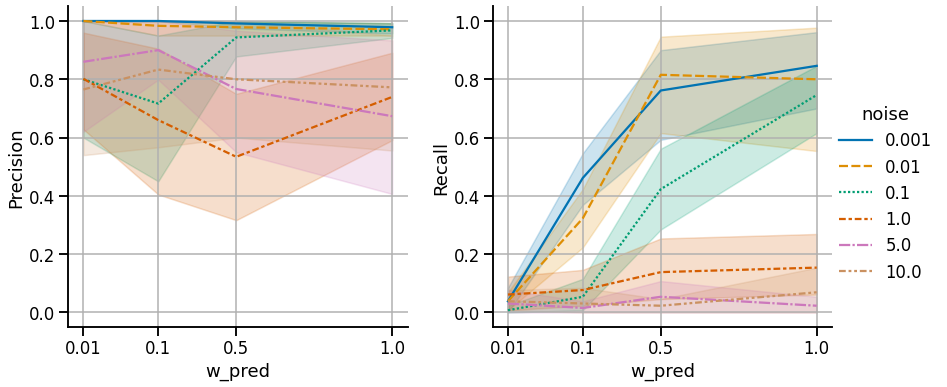

In [188]:
sns.set_context("talk", font_scale=1.0)
g = sns.relplot(
                data = plot_synthetic_df[(plot_synthetic_df.Class=="PRED")
                                                    &(plot_synthetic_df.alpha==0.02)
                                                    &(plot_synthetic_df.N_pred==13)
                                                    &(plot_synthetic_df.N_prog==25)
                                                    ].melt(id_vars=["w_pred","N_pred","N_prog","noise","alpha","random_seed","Class"]),
                kind="line",
                hue="noise",
                style='noise',
                x="w_pred",
                y="value",
                col="variable",
                palette="colorblind",
                row_order=row_order,
                facet_kws={"sharey": False,"sharex":False},
                height=6,
            )

for row_axs, row_name in zip(g.axes, row_names):
    row_axs[0].set_ylabel("Precision")
    row_axs[1].set_ylabel("Recall")

    row_axs[0].set_title("")
    row_axs[1].set_title("")

    row_axs[0].set_ylim([-0.05,1.05])
    row_axs[1].set_ylim([-0.05,1.05])

    row_axs[1].set_xticks(ticks=[0.01,0.25,0.5,1.0])
    row_axs[1].set_xticklabels([0.01,0.1,0.5,1.0])

    row_axs[0].set_xticks(ticks=[0.01,0.25,0.5,1.0])
    row_axs[0].set_xticklabels([0.01,0.1,0.5,1.0])

    for rows in row_axs:
        rows.grid()

    plt.subplots_adjust(wspace=0.25)

plt.savefig("results/figures/semi_synthetic_all_results_"+dataset_string+"_noise.pdf", bbox_inches="tight")

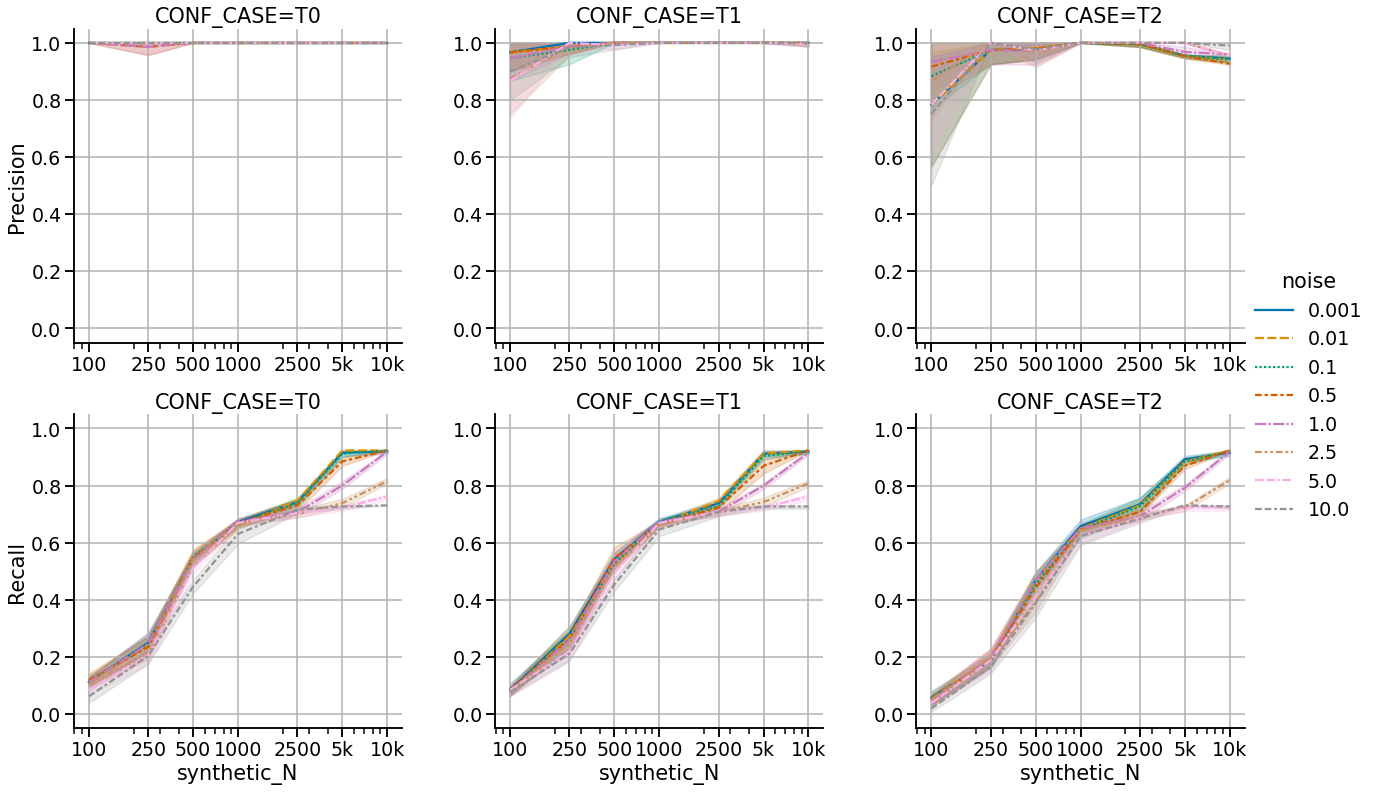

In [183]:

if semi_synthetic_bool:
    for class_pred in ["PRED"]:
        for alpha in [0.02]:
            sns.set_context("talk", font_scale=1.5)
            row_order = ["Precision", "Recall"]
            row_names = ["Precision", "Recall"]

            g = sns.relplot(
                data=plot_synthetic_df[(plot_synthetic_df.Class==class_pred)
                                    &(plot_synthetic_df.alpha==alpha)
                                    &(plot_synthetic_df.noise==noise_level)
                                    ].melt(
                    id_vars=["w_pred","N_pred","N_prog","Class"]
                ),
                kind="line",
                hue="N_pred",
                x="w_pred",
                y="value",
                col="N_prog",
                style="N_pred",
                row="variable",
                palette="colorblind",
                row_order=row_order,
                facet_kws={"sharey": False,"sharex":False},
                height=6,
            )

            axis_all = g.axes
            leg = g._legend

            g.fig.subplots_adjust(top=0.9)

            for axs_row in axis_all:  
                for axs in axs_row:
                    axs.set_ylim([-0.05,1.05])
                
            g.set_titles("{col_var}={col_name}")
            for row_axs, row_name in zip(g.axes, row_names):
                row_axs[0].set_ylabel(row_name)

                for rows in row_axs:
                    rows.grid()
                    rows.set_xticks(ticks=[0.01,0.25,0.5,1.0])
                    rows.set_xticklabels([0.01,0.1,0.5,1.0])
            plt.plot()
            
            plt.savefig("results/figures/semi_synthetic_all_results_"+dataset_string+".jpg", bbox_inches="tight")
            plt.savefig("results/figures/semi_synthetic_all_results_"+dataset_string+".pdf", bbox_inches="tight")
            plt.savefig("results/figures/semi_synthetic_all_results_"+dataset_string+".png", bbox_inches="tight")

            
else:

    for alpha in [0.02]:
        sns.set_context("talk", font_scale=1.15)
        row_order = ["Precision", "Recall"]
        row_names = ["Precision", "Recall"]

        g = sns.relplot(
            data=plot_synthetic_df[(plot_synthetic_df.alpha==alpha)&(plot_synthetic_df.Class=="PRED")].melt(
                id_vars=["synthetic_N","CONF_CASE","noise"]
            ),
            kind="line",
            hue="noise",
            style="noise",
            x="synthetic_N",
            y="value",
            col="CONF_CASE",
            row="variable",
            palette="colorblind",
            row_order=row_order,
            facet_kws={"sharey": False,"sharex":False},
            height=6,
        )

        axis_all = g.axes

        for axs_row in axis_all:  
            for axs in axs_row:
                axs.set_ylim([-0.05,1.05])
            
        g.set_titles("{col_var}={col_name}")

        g.fig.subplots_adjust(top=0.9)

        for row_axs, row_name in zip(g.axes, row_names):
            row_axs[0].set_ylabel(row_name)

            for rows in row_axs:
                rows.grid()
                rows.set_xscale("log")
                rows.set_xticks(ticks=[100,250,500,1000,2500,5000,10000])
                rows.set_xticklabels([100,250,500,1000,2500,"5k","10k"])
            
        plt.savefig("results/figures/full_synthetic_all_results.jpg", bbox_inches="tight")
        plt.savefig("results/figures/full_synthetic_all_results.pdf", bbox_inches="tight")
        plt.savefig("results/figures/full_synthetic_all_results.png", bbox_inches="tight")